# Model 11
## Model 9 but try solwing overfitting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_oyak=pd.read_csv(r"C:\Users\denem\Downloads\OykBlFarnSstmFn.csv")

In [3]:
df_oyak.head()

,time,xVRMS,yVRMS,zVRMS,temp,cf,maxCf
0,2022-06-27 11:35:00,2.3975,1.7435,0.448,50.4,2.685,NaN
1,2022-06-27 11:40:00,2.3110,1.8080,0.524,49.9,2.480,NaN
2,2022-06-27 11:45:00,2.3520,1.7020,0.451,50.5,2.570,NaN
3,2022-06-27 11:55:00,2.4500,1.6380,0.469,50.4,2.460,NaN
4,2022-06-27 12:00:00,2.3680,1.7200,0.436,50.8,2.290,NaN


In [4]:
new_df_oyk=df_oyak.sort_values("time")

In [5]:
df2_x=new_df_oyk["xVRMS"]

In [6]:
df2_x.isnull().sum()

3

In [7]:
df2_x=df2_x.fillna(df2_x.mean())

In [8]:
df2_x.isnull().sum()

0

In [9]:
df2_x.index = pd.to_datetime(new_df_oyk["time"])

In [10]:
df2_x.tail()

time
2023-04-24 21:10:00    4.53544
2023-04-24 21:15:00    4.50937
2023-04-24 21:20:00    4.41924
2023-04-24 21:25:00    4.49352
2023-04-24 21:30:00    4.53100
Name: xVRMS, dtype: float64

In [11]:
def clean_limit(df_column, low_limit, up_limit=None):
    if up_limit is None:
        filtered = df_column[(df_column >= low_limit)]
        
    else:
        filtered = df_column.loc[(df_column >= low_limit) & (df_column <= up_limit)]
    return filtered

In [12]:
df2_x=clean_limit(df2_x,low_limit=0.5)

## 3 sigma

In [13]:
process_clm = df2_x
process_clm_mean = process_clm.mean()
process_clm_std = process_clm.std()

up_limit = process_clm_mean + 3 * process_clm_std
low_limit = process_clm_mean - 3 * process_clm_std

process_clm_mean,process_clm_std,up_limit,low_limit

(3.522406619639381, 0.9837945762157837, 6.473790348286732, 0.5710228909920296)

In [14]:
len(df2_x)

58688

In [15]:
df_x2=clean_limit(df2_x,low_limit=0.5710228909920296,up_limit=6.473790348286732)

In [16]:
 df2_x = df2_x.loc[(df2_x >= low_limit) & (df2_x <= up_limit)]

In [17]:

len(df2_x)

58328

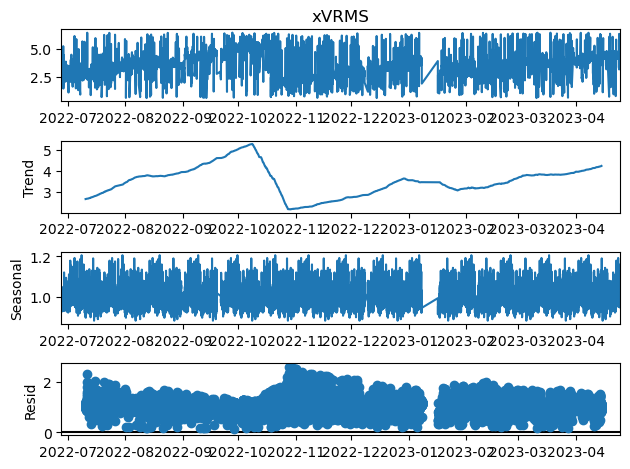

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_x2, model='multiplicative',period=4096)
result.plot()
plt.show()

In [19]:
WINDOW_SIZE=5

In [20]:
def df_to_X_y(df, window_size=5):
  """
  Converts a pandas DataFrame to a tuple of NumPy arrays, where X is the input data and y is the target data.

  Args:
    df: A pandas DataFrame.
    window_size: The size of the sliding window.

  Returns:
    A tuple of NumPy arrays, where X is the input data and y is the target data.
  """

  # Convert the DataFrame to a NumPy array.
  df_as_np = df.to_numpy()

  # Create the input and target data.
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = df_as_np[i:i + window_size]
    X.append(row)
    label = df_as_np[i + window_size]
    y.append(label)

  # Return the input and target data as NumPy arrays.
  return np.array(X), np.array(y)

In [21]:
X,y =df_to_X_y(df2_x,WINDOW_SIZE)
X.shape,y.shape

((58323, 5), (58323,))

In [22]:
total_size = len(X)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)

X_train, y_train = X[:train_size], y[:train_size]  # %80
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]  # %10
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]  # %10

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((46658, 5), (46658,), (5832, 5), (5832,), (5833, 5), (5833,))

In [23]:
# Assuming X_train, X_val, and X_test are your input features
# Assuming y_train, y_val, and y_test are your target variables

# Create a MinMaxScaler object for the input features
scaler = MinMaxScaler()

# Fit the scaler on the training input features
scaler.fit(X_train)

# Apply normalization to the input features
X_train_normalized = scaler.transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [25]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.engine.input_layer import InputLayer

# Rest of your code
model11 = Sequential()
model11.add(InputLayer((WINDOW_SIZE, 1)))
model11.add(LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model11.add(Dropout(0.2))
model11.add(LSTM(64, kernel_regularizer=regularizers.l2(0.01)))
model11.add(Dropout(0.2))
model11.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model11.add(Dense(1, activation='linear'))

# Compile the model
model11.compile(loss="mse", optimizer=Adam(learning_rate=0.001))
best_model_weights = ModelCheckpoint("model11.h5", monitor="val_loss", save_best_only=True)
# Apply early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Fit the model
model11.fit(X_train_normalized, y_train, batch_size=64, epochs=100, validation_data=(X_val_normalized, y_val), callbacks=[best_model_weights, early_stopping])



Epoch 1/100
730/730 [==============================] - 7s 7ms/step - loss: 0.8307 - val_loss: 0.2908
Epoch 2/100
730/730 [==============================] - 5s 6ms/step - loss: 0.2680 - val_loss: 0.2210
Epoch 3/100
730/730 [==============================] - 5s 6ms/step - loss: 0.2296 - val_loss: 0.2457
Epoch 4/100
730/730 [==============================] - 5s 7ms/step - loss: 0.2093 - val_loss: 0.1922
Epoch 5/100
730/730 [==============================] - 5s 7ms/step - loss: 0.1952 - val_loss: 0.1824
Epoch 6/100
730/730 [==============================] - 5s 6ms/step - loss: 0.1798 - val_loss: 0.2002
Epoch 7/100
730/730 [==============================] - 5s 7ms/step - loss: 0.1668 - val_loss: 0.1816
Epoch 8/100
730/730 [==============================] - 5s 6ms/step - loss: 0.1577 - val_loss: 0.1996
Epoch 9/100
730/730 [==============================] - 5s 6ms/step - loss: 0.1514 - val_loss: 0.1853
Epoch 10/100
730/730 [==============================] - 4s 6ms/step - loss: 0.1469 - val_lo

In [26]:
train_predictions = model11.predict(X_train_normalized).flatten()
train_results = pd.DataFrame(data={"Train Predictions": train_predictions, "Actuals": y_train.flatten()})
train_results[:30]

1459/1459 [==============================] - 3s 2ms/step


,Train Predictions,Actuals
0,2.425830,2.3800
1,2.483165,2.2610
2,2.506627,2.3590
3,2.478499,2.5840
4,2.490279,2.6590
5,2.447786,2.5500
6,2.594772,2.5930
7,2.665710,2.7340
8,2.676982,2.6375
9,2.658079,2.7020


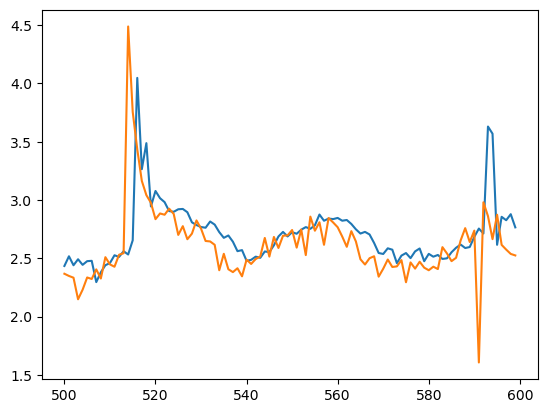

In [27]:
plt.plot(train_results["Train Predictions"][500:600])
plt.plot(train_results["Actuals"][500:600])

In [28]:
val_predictions=model11.predict(X_val_normalized).flatten()
val_results=pd.DataFrame(data={"Val Predictions": val_predictions,"Actuals":y_val.flatten()})
val_results

183/183 [==============================] - 0s 2ms/step


,Val Predictions,Actuals
0,3.924983,3.79186
1,3.760676,3.67819
2,3.763391,3.83377
3,3.739616,3.81646
4,3.790337,3.78432
...,...,...
5827,3.938009,3.98899
5828,3.935452,4.10313
5829,3.959553,4.06409
5830,4.015121,4.00981


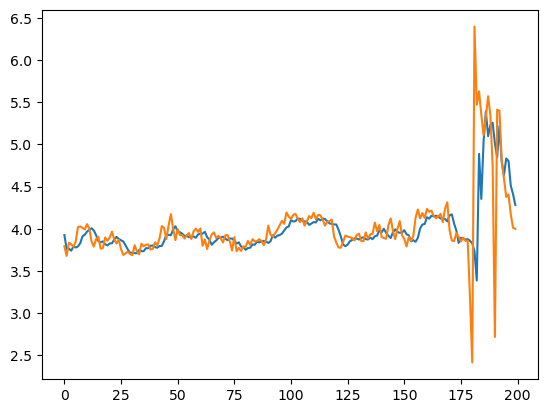

In [29]:
plt.plot(val_results["Val Predictions"][:200])
plt.plot(val_results["Actuals"][:200])

In [30]:
test_predictions=model11.predict(X_test_normalized).flatten()
test_results=pd.DataFrame(data={"Test Predictions": test_predictions,"Actuals":y_test.flatten()})
test_results

183/183 [==============================] - 0s 2ms/step


,Test Predictions,Actuals
0,4.011942,4.02613
1,4.053944,4.03413
2,4.016503,4.02290
3,4.019440,4.04984
4,4.011765,4.03620
...,...,...
5828,4.492029,4.53544
5829,4.463121,4.50937
5830,4.470188,4.41924
5831,4.453193,4.49352


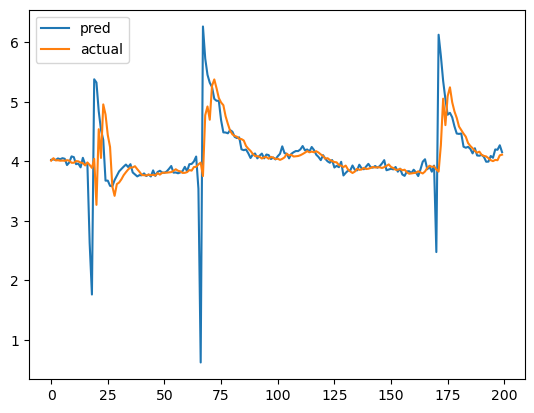

In [31]:
plt.plot(test_results["Actuals"][:200])
plt.plot(test_results["Test Predictions"][:200])
plt.legend(labels=["pred", "actual"])

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Get the model's predictions
y_train_pred = train_predictions
y_val_pred = val_predictions
y_test_pred =test_predictions

# Calculate the regression metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

rmse_train = np.sqrt(mse_train)
rmse_val = np.sqrt(mse_val)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print("Regression Metrics:")
print("MAE - Train:", mae_train)
print("MAE - Validation:", mae_val)
print("MAE - Test:", mae_test)
print("MSE - Train:", mse_train)
print("MSE - Validation:", mse_val)
print("MSE - Test:", mse_test)
print("RMSE - Train:", rmse_train)
print("RMSE - Validation:", rmse_val)
print("RMSE - Test:", rmse_test)
print("R^2 Score - Train:", r2_train)
print("R^2 Score - Validation:", r2_val)
print("R^2 Score - Test:", r2_test)


Regression Metrics:
MAE - Train: 0.14724228300141312
MAE - Validation: 0.1268564134196424
MAE - Test: 0.11727981734540191
MSE - Train: 0.08739247238157115
MSE - Validation: 0.10594983940428286
MSE - Test: 0.08567388777836324
RMSE - Train: 0.29562217843316685
RMSE - Validation: 0.32549936928400164
RMSE - Test: 0.29270102114335583
R^2 Score - Train: 0.9073231395056361
R^2 Score - Validation: 0.5270058306443985
R^2 Score - Test: 0.5286674981819812
